# Deep Emulator in the Kato-Phillips Case: Preprocessing Data

We preprocess data from simulations of the Kato-Phillips case to prepare the training of a neural network. It will learn the evolution of a temperature and salinity vertical profile depending on various initial conditions.
The set of simulations is based on the work of Gabriel Mouttapa on the _Tunax_ package and its application to the Kato-Phillips case.

In this notebook we normalize data, and split it into train and test data sets.

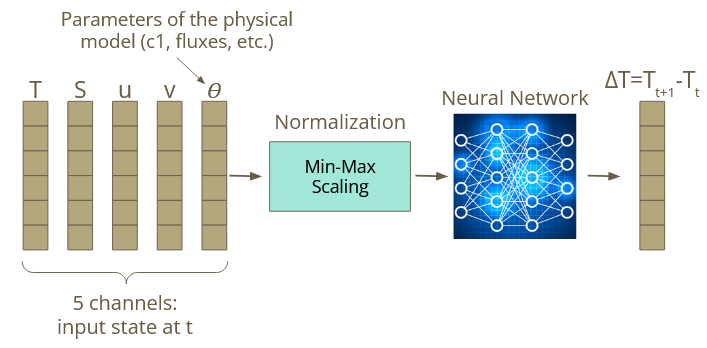

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
Image('data_process.png')

In [11]:
# metadata to be stored

n_sim = 100 # number of simulations
norm_factor = 25.0 # the initial temperature is always below 25.0°C

### 1. Imports

In [12]:
# Useful libraries
import os
import xarray as xr
import numpy as np

### 2. Normalize Data and Generate Labels

The inputs for Neural Networks need to be preprocessed. We normalize data so that every data point is in the unit circle. Here only the temperature and $c_1$ parameter need to be normalized. Labels are normalized as well.

We define the labels of a state $s_t = (T_t, S_t, u_t, v_t, \theta_t)$ as $\Delta T_t = T_{t+1} - T_t$. $\theta_t$ is the vector of parameters containing the slope of the initial temperature, the zonal wind friction velocity, and the pressure/velocity dissipation tensor $c_1$.

In [ ]:
def preprocess_and_generate_labels(file_paths, norm_factor=25.0):
    """
    Preprocess NetCDF files to create normalized input data and labels.
    
    Parameters:
        file_paths: list of str
            List of paths to NetCDF files.

    Returns:
        combined_data: np.ndarray
            Data frame of stacked normalized data, dimensions: (total_time-len(file_paths), 50, 5).
        labels: np.ndarray
            Data frame of labels, dimensions: (total_time-len(file_paths), 50).
        min_vals: np.array
            Vector of size 5 (minimum of each channel over time and space).
        max_vals: np.array
            Vector of size 5 (maximum of each channel over time and space).
    """
    all_data = []  # To store preprocessed data from all files
    all_labels = []  # To store labels from all files

    for file_path in file_paths:

        # Load NetCDF file
        data = xr.open_dataset(file_path)

        # Extract time dimension
        time_dim = data.dims['time']
        time_dim = time_dim - 1  # Remove last time step - no prediction available for the next state

        # Extract variables
        temperature = data['t'].values/norm_factor
        salinity = data['s'].values/norm_factor/2 # normalize salinity
        u_velocity = data['u'].values
        v_velocity = data['v'].values
        # we only normalize temperature and salinity as the other variables are already in the unit circle

        # Create a 5th channel containing the varying parameters (strat_t, u, c1) in the first positions
        custom_channel = np.zeros((time_dim,))
        custom_channel[0] = data.attrs.get('strat_t', 0.0)
        custom_channel[1] = data.attrs.get('u', 0.0)
        custom_channel[2] = data.attrs.get('c1', 0.0)/norm_factor # only parameter that needs to be normalized
        

        # Merge as a full matrix (time_dim, 5, depth)
        processed_data = np.stack([
            temperature[:time_dim, :],
            salinity[:time_dim, :],
            u_velocity[:time_dim, :],
            v_velocity[:time_dim, :],
            np.tile(custom_channel, (len(temperature[0]), 1)).T
        ], axis=1)
        

        # Compute labels (temperature delta between t and t+1)
        labels = temperature[1:] - temperature[:-1]

        # Store results
        all_data.append(processed_data)
        all_labels.append(labels)

    # Concatenate all matrices
    combined_data = np.vstack(all_data)
    combined_labels = np.concatenate(all_labels)

    return combined_data, combined_labels

In [20]:
directory = "data/"  # where simulations files are stored
file_names = [f"traj{i}.nc" for i in range(n_sim)]
file_paths = [os.path.join(directory, name) for name in file_names]

# Preprocess data and generate labels
combined_data, labels = preprocess_and_generate_labels(file_paths)

# Print dimensions of preprocessed data
print("Combined data shape:", combined_data.shape)
print("Labels shape:", labels.shape)

# Save results
np.save("data/normalized_combined_processed_data.npy", combined_data)
np.save("data/labels_normalized_data.npy", labels)

/tmp/ipykernel_9971/3918411956.py:28: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  time_dim = data.dims['time']


Combined data shape: (35900, 5, 50)
Labels shape: (35900, 50)


### 3. Shuffle and Split into Train and Test Sets

We now shuffle data to train the network on randomly-selected pairs (data point, label). $20\%$ of the data is kept for validation purposes, i.e. to check that the network is not overfitting the data.

In [21]:
def split_data_and_labels(data, labels, n_sim, train_ratio=0.8, random_seed=None):
    """
    Splits data and labels into train and test sets.

    Parameters:
        data: np.ndarray
            Input data frame, dimensions: (n_sim*n_time, num_features, depth).
        labels: np.ndarray
            Labels, dimensions: (n_sim*n_time,depth).
        train_ratio: float
            Data proportion for training (default 0.8).
        random_seed: int or None
            Random seed for reproducibility (default None).

    Returns:
        train_data: np.ndarray
        train_labels: np.ndarray
        test_data: np.ndarray
        test_labels: np.ndarray
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    n_time = data.shape[0] // n_sim
    
    # Choose random indices in n_sim
    indices = np.arange(n_sim)
    np.random.shuffle(indices)
    
    # Indices for train and test sets knowing that data is ordered by simulation
    train_indices = np.array([])
    for i in indices[:int(train_ratio*n_sim)]:
        # Add indices corresponding to the i-th simulation
        train_indices = np.append(train_indices, np.arange(i*n_time, (i+1)*n_time))
    
    # Convert to integers
    train_indices = train_indices.astype(int)
    
    # Split data and labels into train and test sets
    train_data = data[train_indices]
    train_labels = labels[train_indices]
    test_data = np.delete(data, train_indices, axis=0)
    test_labels = np.delete(labels, train_indices, axis=0)

    return train_data, train_labels, test_data, test_labels, train_indices

In [22]:
# Load pre-processed data and labels
combined_data = np.load("data/normalized_combined_processed_data.npy")
labels = np.load("data/labels_normalized_data.npy")

# Split them up
train_data, train_labels, test_data, test_labels, train_indices = split_data_and_labels(
    combined_data, labels, n_sim, train_ratio=0.8, random_seed=42
)

# Print their respective size
print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)

# Save each data set
np.save("data/train_data.npy", train_data)
np.save("data/train_labels.npy", train_labels)
np.save("data/test_data.npy", test_data)
np.save("data/test_labels.npy", test_labels)

Train data shape: (28720, 5, 50)
Train labels shape: (28720, 50)
Test data shape: (7180, 5, 50)
Test labels shape: (7180, 50)


In [23]:
# save indices to be reused
np.save("data/train_indices.npy", train_indices)

In [24]:
train_data.shape

(28720, 5, 50)

### 4. Normalize Inference Data

In [25]:
inf_file_names = [f"inf_traj{i}.nc" for i in range(n_sim)]
inf_file_paths = [os.path.join(directory, name) for name in file_names]

# Preprocess data and generate labels
inf_combined_data, inf_labels = preprocess_and_generate_labels(file_paths, norm_factor)

# Print dimensions of preprocessed data
print("Combined data shape:", inf_combined_data.shape)
print("Labels shape:", inf_labels.shape)

# Save results
np.save("data/inf_combined_data.npy", inf_combined_data)
np.save("data/inf_labels.npy", inf_labels)

/tmp/ipykernel_9971/3918411956.py:28: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  time_dim = data.dims['time']


Combined data shape: (35900, 5, 50)
Labels shape: (35900, 50)
